# GNN 기반 영화 추천 시스템
# V6: 공격적 데이터 Filtering + Threshold 제거
# 진단 결과 기반 데이터 품질 대폭 개선

In [1]:
import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 60)
print("환경 설정")
print("=" * 60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")
print("=" * 60)

환경 설정
PyTorch 버전: 2.9.0
CUDA 사용 가능: False
MPS 사용 가능: True


In [2]:
# 하이퍼파라미터 설정 (V6 - Aggressive Filtering)
CONFIG = {
    # Filtering 기준 (⭐ 핵심 변경!)
    'min_user_interactions': 30,   # V5: 없음 → V6: 30
    'min_item_interactions': 10,   # V5: 없음 → V6: 10
    'rating_threshold': None,      # V5: 3.5 → V6: None (모든 rating 사용!)
    
    # Split 비율 (Valid 증가)
    'train_ratio': 0.70,
    'valid_ratio': 0.15,  # V5: 0.10 → V6: 0.15
    'test_ratio': 0.15,   # V5: 0.20 → V6: 0.15
    
    # 모델 파라미터 (V5와 동일)
    'embedding_dim': 64,
    'n_layers': 2,
    
    # 학습 파라미터
    # 'learning_rate': 0.0005,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'batch_size': 512,
    'epochs': 100,
    'patience': 20,       # V5: 15 → V6: 20 (여유있게)
    'neg_ratio': 4,
    
    # 평가
    'top_k': 10,
    
    # 시스템
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'seed': 42,
    
    # 경로
    'data_dir': '../data',
    'processed_dir': '../data/processed',
    'model_dir': '../models',
    'result_dir': '../results',
}

# 폴더 생성
for dir_path in [CONFIG['processed_dir'], CONFIG['model_dir'], CONFIG['result_dir']]:
    os.makedirs(dir_path, exist_ok=True)

# Random seed 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(CONFIG['seed'])

print("=" * 60)
print("V6 설정 완료! (공격적 Filtering)")
print("=" * 60)
print(f"Device: {CONFIG['device']}")
print(f"\n⭐ 핵심 변경사항:")
print(f"  User minimum: {CONFIG['min_user_interactions']} interactions")
print(f"  Item minimum: {CONFIG['min_item_interactions']} interactions")
print(f"  Rating threshold: {CONFIG['rating_threshold']} (모든 rating 사용!)")
print(f"  Valid ratio: {CONFIG['valid_ratio']} (0.10 → 0.15)")
print(f"\n모델 설정 (V5와 동일):")
print(f"  Embedding dim: {CONFIG['embedding_dim']}")
print(f"  Layers: {CONFIG['n_layers']}")
print(f"  Negative ratio: {CONFIG['neg_ratio']}")
print(f"  Patience: {CONFIG['patience']}")
print("=" * 60)
print("\n🎯 목표: 데이터 품질 향상으로 Graph 효과 극대화!")
print("=" * 60)

V6 설정 완료! (공격적 Filtering)
Device: mps

⭐ 핵심 변경사항:
  User minimum: 30 interactions
  Item minimum: 10 interactions
  Rating threshold: None (모든 rating 사용!)
  Valid ratio: 0.15 (0.10 → 0.15)

모델 설정 (V5와 동일):
  Embedding dim: 64
  Layers: 2
  Negative ratio: 4
  Patience: 20

🎯 목표: 데이터 품질 향상으로 Graph 효과 극대화!


## 데이터 로드 및 Filtering

In [3]:
# 원본 데이터 로드
df = pd.read_csv(os.path.join(CONFIG['data_dir'], 'train.csv'))

print("=" * 60)
print("원본 데이터")
print("=" * 60)
print(f"총 interactions: {len(df):,}")
print(f"Users: {df['user'].nunique():,}")
print(f"Items: {df['item'].nunique():,}")
print(f"\nRating 분포:")
print(df['rating'].describe())
print(f"\nRating >= 3.5: {(df['rating'] >= 3.5).sum():,} ({(df['rating'] >= 3.5).sum()/len(df)*100:.1f}%)")
print(f"Rating < 3.5:  {(df['rating'] < 3.5).sum():,} ({(df['rating'] < 3.5).sum()/len(df)*100:.1f}%)")

원본 데이터
총 interactions: 105,139
Users: 668
Items: 10,321

Rating 분포:
count    105139.000000
mean          3.517049
std           1.044640
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Rating >= 3.5: 64,054 (60.9%)
Rating < 3.5:  41,085 (39.1%)


In [4]:
# Rating threshold 제거 (모든 rating 사용)
print("=" * 60)
print("Step 1: Rating Threshold 제거")
print("=" * 60)

if CONFIG['rating_threshold'] is not None:
    df_filtered = df[df['rating'] >= CONFIG['rating_threshold']].copy()
    print(f"Threshold {CONFIG['rating_threshold']} 적용: {len(df_filtered):,}개 ({len(df_filtered)/len(df)*100:.1f}%)")
else:
    df_filtered = df.copy()
    print(f"⭐ Threshold 없음: 모든 {len(df_filtered):,}개 rating 사용!")
    print(f"  → V5 대비 {len(df) - 64054:,}개 데이터 추가 활용")

Step 1: Rating Threshold 제거
⭐ Threshold 없음: 모든 105,139개 rating 사용!
  → V5 대비 41,085개 데이터 추가 활용


In [5]:
# 반복적 Filtering (User/Item minimum)
print("\n" + "=" * 60)
print("Step 2: 반복적 Filtering (User >= 30, Item >= 10)")
print("=" * 60)

def iterative_filtering(df, min_user, min_item, max_iter=10):
    """User와 Item 최소 interaction 조건을 만족할 때까지 반복"""
    df_work = df.copy()
    
    for iteration in range(max_iter):
        start_len = len(df_work)
        
        # User filtering
        user_counts = df_work['user'].value_counts()
        valid_users = user_counts[user_counts >= min_user].index
        df_work = df_work[df_work['user'].isin(valid_users)]
        
        # Item filtering
        item_counts = df_work['item'].value_counts()
        valid_items = item_counts[item_counts >= min_item].index
        df_work = df_work[df_work['item'].isin(valid_items)]
        
        end_len = len(df_work)
        
        print(f"  Iteration {iteration+1}: {start_len:,} → {end_len:,} "
              f"({end_len-start_len:+,}, "
              f"Users: {df_work['user'].nunique()}, "
              f"Items: {df_work['item'].nunique()})")
        
        if start_len == end_len:
            print(f"  ✓ 수렴 완료 (iteration {iteration+1})")
            break
    
    return df_work

df_filtered = iterative_filtering(
    df_filtered,
    CONFIG['min_user_interactions'],
    CONFIG['min_item_interactions']
)

print("\n최종 결과:")
print(f"  Interactions: {len(df):,} → {len(df_filtered):,} ({len(df_filtered)/len(df)*100:.1f}%)")
print(f"  Users: {df['user'].nunique()} → {df_filtered['user'].nunique()} "
      f"({df_filtered['user'].nunique()/df['user'].nunique()*100:.1f}%)")
print(f"  Items: {df['item'].nunique()} → {df_filtered['item'].nunique()} "
      f"({df_filtered['item'].nunique()/df['item'].nunique()*100:.1f}%)")


Step 2: 반복적 Filtering (User >= 30, Item >= 10)
  Iteration 1: 105,139 → 80,993 (-24,146, Users: 546, Items: 2291)
  Iteration 2: 80,993 → 80,470 (-523, Users: 529, Items: 2283)
  Iteration 3: 80,470 → 80,470 (+0, Users: 529, Items: 2283)
  ✓ 수렴 완료 (iteration 3)

최종 결과:
  Interactions: 105,139 → 80,470 (76.5%)
  Users: 668 → 529 (79.2%)
  Items: 10321 → 2283 (22.1%)


In [6]:
# Filtering 전후 통계 비교
print("\n" + "=" * 60)
print("Filtering 전후 비교")
print("=" * 60)

# 원본
orig_user_counts = df['user'].value_counts()
orig_item_counts = df['item'].value_counts()

# Filtering 후
filt_user_counts = df_filtered['user'].value_counts()
filt_item_counts = df_filtered['item'].value_counts()

print("\nUser interactions:")
print(f"  원본 - Mean: {orig_user_counts.mean():.1f}, Median: {orig_user_counts.median():.1f}")
print(f"  필터 - Mean: {filt_user_counts.mean():.1f}, Median: {filt_user_counts.median():.1f}")
print(f"  변화: {filt_user_counts.mean() / orig_user_counts.mean():.2f}x")

print("\nItem interactions:")
print(f"  원본 - Mean: {orig_item_counts.mean():.1f}, Median: {orig_item_counts.median():.1f}")
print(f"  필터 - Mean: {filt_item_counts.mean():.1f}, Median: {filt_item_counts.median():.1f}")
print(f"  ⭐ 변화: {filt_item_counts.mean() / orig_item_counts.mean():.2f}x (목표: 2x 이상!)")

print("\nSparsity:")
orig_sparsity = 100 * (1 - len(df) / (df['user'].nunique() * df['item'].nunique()))
filt_sparsity = 100 * (1 - len(df_filtered) / (df_filtered['user'].nunique() * df_filtered['item'].nunique()))
print(f"  원본: {orig_sparsity:.2f}%")
print(f"  필터: {filt_sparsity:.2f}%")
print(f"  ⭐ 개선: {orig_sparsity - filt_sparsity:+.2f}%p")


Filtering 전후 비교

User interactions:
  원본 - Mean: 157.4, Median: 70.0
  필터 - Mean: 152.1, Median: 86.0
  변화: 0.97x

Item interactions:
  원본 - Mean: 10.2, Median: 3.0
  필터 - Mean: 35.2, Median: 22.0
  ⭐ 변화: 3.46x (목표: 2x 이상!)

Sparsity:
  원본: 98.48%
  필터: 93.34%
  ⭐ 개선: +5.14%p


In [7]:
# ID Re-indexing
print("\n" + "=" * 60)
print("ID Re-indexing")
print("=" * 60)

# 고유 ID 추출
unique_users = sorted(df_filtered['user'].unique())
unique_items = sorted(df_filtered['item'].unique())

print(f"고유 사용자: {len(unique_users)}")
print(f"고유 아이템: {len(unique_items)}")

# Mapping 생성
user_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_users)}
item_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_items)}
user_id_reverse = {v: k for k, v in user_id_map.items()}
item_id_reverse = {v: k for k, v in item_id_map.items()}

# DataFrame에 새로운 ID 적용
df_filtered['user_id'] = df_filtered['user'].map(user_id_map)
df_filtered['item_id'] = df_filtered['item'].map(item_id_map)

# Mapping 저장
mappings = {
    'user_id_map': user_id_map,
    'item_id_map': item_id_map,
    'user_id_reverse': user_id_reverse,
    'item_id_reverse': item_id_reverse,
}

with open(os.path.join(CONFIG['processed_dir'], 'id_mappings_v6.pkl'), 'wb') as f:
    pickle.dump(mappings, f)

print(f"\n변환 완료!")
print(f"User ID: 0 ~ {len(unique_users)-1}")
print(f"Item ID: 0 ~ {len(unique_items)-1}")

n_users = len(unique_users)
n_items = len(unique_items)


ID Re-indexing
고유 사용자: 529
고유 아이템: 2283

변환 완료!
User ID: 0 ~ 528
Item ID: 0 ~ 2282


## Train/Valid/Test Split

In [8]:
# Train/Valid/Test Split (70/15/15)
print("=" * 60)
print("Train/Valid/Test Split (V6: 70/15/15)")
print("=" * 60)

def split_user_interactions(group, train_r=0.7, valid_r=0.15, test_r=0.15, seed=42):
    """각 user의 상호작용을 train/valid/test로 분할"""
    n = len(group)
    indices = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    train_end = int(n * train_r)
    valid_end = train_end + int(n * valid_r)
    
    train_idx = indices[:train_end]
    valid_idx = indices[train_end:valid_end]
    test_idx = indices[valid_end:]
    
    return train_idx, valid_idx, test_idx

# User별로 split
train_list, valid_list, test_list = [], [], []

for user_id, group in df_filtered.groupby('user_id'):
    train_idx, valid_idx, test_idx = split_user_interactions(
        group, 
        CONFIG['train_ratio'], 
        CONFIG['valid_ratio'], 
        CONFIG['test_ratio'],
        CONFIG['seed']
    )
    
    train_list.append(group.iloc[train_idx])
    valid_list.append(group.iloc[valid_idx])
    test_list.append(group.iloc[test_idx])

train_df = pd.concat(train_list, ignore_index=True)
valid_df = pd.concat(valid_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"\nSplit 결과:")
print(f"Train: {len(train_df):,} ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"Valid: {len(valid_df):,} ({len(valid_df)/len(df_filtered)*100:.1f}%)")
print(f"Test:  {len(test_df):,} ({len(test_df)/len(df_filtered)*100:.1f}%)")

# Split 품질 확인
print(f"\nSplit 품질 (User당 평균 items):")
print(f"  Train: {train_df.groupby('user_id').size().mean():.1f}")
print(f"  Valid: {valid_df.groupby('user_id').size().mean():.1f}")
print(f"  Test:  {test_df.groupby('user_id').size().mean():.1f}")

# 저장
train_df.to_csv(os.path.join(CONFIG['processed_dir'], 'train_split_v6.csv'), index=False)
valid_df.to_csv(os.path.join(CONFIG['processed_dir'], 'valid_split_v6.csv'), index=False)
test_df.to_csv(os.path.join(CONFIG['processed_dir'], 'test_split_v6.csv'), index=False)

print("\nSplit 데이터 저장 완료!")

Train/Valid/Test Split (V6: 70/15/15)

Split 결과:
Train: 56,072 (69.7%)
Valid: 11,826 (14.7%)
Test:  12,572 (15.6%)

Split 품질 (User당 평균 items):
  Train: 106.0
  Valid: 22.4
  Test:  23.8

Split 데이터 저장 완료!


## Graph 구성 및 통계

In [9]:
# Graph 구성
print("=" * 60)
print("Graph 구성")
print("=" * 60)

def create_graph(df, n_users, n_items):
    """User-Item Bipartite Graph 생성"""
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users
    
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    print(f"Node 수: {n_users + n_items} (User: {n_users}, Item: {n_items})")
    print(f"Edge 수: {edge_index.shape[1]:,} (양방향)")
    
    return edge_index

print("\n[1] Train Graph (학습용)")
train_edge_index = create_graph(train_df, n_users, n_items)

print("\n[2] Train+Valid Graph (Test 평가용)")
train_valid_df = pd.concat([train_df, valid_df])
train_valid_edge_index = create_graph(train_valid_df, n_users, n_items)

print("\n✅ Graph 생성 완료!")

Graph 구성

[1] Train Graph (학습용)
Node 수: 2812 (User: 529, Item: 2283)
Edge 수: 112,144 (양방향)

[2] Train+Valid Graph (Test 평가용)
Node 수: 2812 (User: 529, Item: 2283)
Edge 수: 135,796 (양방향)

✅ Graph 생성 완료!


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_92491/3903611053.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


In [10]:
# Graph 통계 (V5와 비교)
print("\n" + "=" * 60)
print("Graph 통계 (V6 vs V5)")
print("=" * 60)

item_degree = train_df.groupby('item_id').size()
user_degree = train_df.groupby('user_id').size()

print("\nItem Degree:")
print(f"  Mean:   {item_degree.mean():.1f} (V5: 7.0)")
print(f"  Median: {item_degree.median():.1f} (V5: ~4)")
print(f"  Min:    {item_degree.min()} (V5: 1)")
print(f"  Max:    {item_degree.max()} (V5: ~600)")

print("\nUser Degree:")
print(f"  Mean:   {user_degree.mean():.1f} (V5: 66.7)")
print(f"  Median: {user_degree.median():.1f} (V5: 31.0)")

print("\n⭐ User-Item Degree 비율:")
print(f"  V6: {user_degree.mean() / item_degree.mean():.1f}x (V5: 9.6x)")
print(f"  목표: 5x 이하 (더 균형잡힌 graph)")

print("\nLow Degree Items:")
for threshold in [5, 10, 15, 20]:
    pct = (item_degree <= threshold).sum() / len(item_degree) * 100
    print(f"  Degree <= {threshold:2d}: {pct:5.1f}%")
    
print("\n✅ V5 대비 개선:")
print(f"  - Item 평균 degree 증가: 7.0 → {item_degree.mean():.1f} ({item_degree.mean()/7.0:.1f}x)")
print(f"  - User-Item 불균형 감소: 9.6x → {user_degree.mean() / item_degree.mean():.1f}x")


Graph 통계 (V6 vs V5)

Item Degree:
  Mean:   24.6 (V5: 7.0)
  Median: 15.0 (V5: ~4)
  Min:    2 (V5: 1)
  Max:    222 (V5: ~600)

User Degree:
  Mean:   106.0 (V5: 66.7)
  Median: 60.0 (V5: 31.0)

⭐ User-Item Degree 비율:
  V6: 4.3x (V5: 9.6x)
  목표: 5x 이하 (더 균형잡힌 graph)

Low Degree Items:
  Degree <=  5:   2.4%
  Degree <= 10:  30.5%
  Degree <= 15:  50.2%
  Degree <= 20:  62.5%

✅ V5 대비 개선:
  - Item 평균 degree 증가: 7.0 → 24.6 (3.5x)
  - User-Item 불균형 감소: 9.6x → 4.3x


## 모델 정의 (V5와 동일)

In [11]:
# Negative Sampling
def create_user_item_dict(df):
    """User별로 상호작용한 item 집합 생성"""
    user_items = defaultdict(set)
    for _, row in df.iterrows():
        user_items[row['user_id']].add(row['item_id'])
    return user_items

def negative_sampling(df, user_items_dict, n_items, neg_ratio=1):
    """Random negative sampling"""
    pos_users = df['user_id'].values
    pos_items = df['item_id'].values
    
    neg_users = []
    neg_items = []
    
    for user_id, pos_item in zip(pos_users, pos_items):
        user_pos_items = user_items_dict[user_id]
        
        for _ in range(neg_ratio):
            while True:
                neg_item = random.randint(0, n_items - 1)
                if neg_item not in user_pos_items:
                    break
            
            neg_users.append(user_id)
            neg_items.append(neg_item)
    
    return np.array(neg_users), np.array(neg_items)

train_user_items = create_user_item_dict(train_df)
train_valid_user_items = create_user_item_dict(train_valid_df)

print("User-item dictionary 생성 완료!")

User-item dictionary 생성 완료!


In [12]:
# LightGCN 모델
class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer"""
    def __init__(self):
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    """LightGCN for Recommendation"""
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        
        user_final = final_emb[:self.n_users]
        item_final = final_emb[self.n_users:]
        
        return user_final, item_final
    
    def predict(self, users, items, edge_index):
        user_emb, item_emb = self.forward(edge_index)
        user_emb = user_emb[users]
        item_emb = item_emb[items]
        scores = (user_emb * item_emb).sum(dim=1)
        return scores

print("LightGCN 모델 정의 완료!")

LightGCN 모델 정의 완료!


In [13]:
# BPR Loss
def bpr_loss(pos_scores, neg_scores, neg_ratio=1):
    """BPR Loss"""
    if neg_ratio > 1:
        batch_size = pos_scores.size(0)
        neg_scores = neg_scores.view(batch_size, neg_ratio)
        pos_scores_expanded = pos_scores.unsqueeze(1).expand_as(neg_scores)
        loss = -torch.log(torch.sigmoid(pos_scores_expanded - neg_scores) + 1e-10).mean()
    else:
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()
    
    return loss

print("Loss 함수 정의 완료!")

Loss 함수 정의 완료!


In [14]:
# 평가 함수
def evaluate_model(model, edge_index, eval_df, user_items_dict, n_items, k=10, device='cpu'):
    """모델 평가: Precision@K, Recall@K, NDCG@K"""
    model.eval()
    
    with torch.no_grad():
        user_emb, item_emb = model(edge_index.to(device))
        
        precisions, recalls, ndcgs = [], [], []
        
        for user_id, group in eval_df.groupby('user_id'):
            true_items = set(group['item_id'].values)
            exclude_items = user_items_dict[user_id]
            
            user_emb_single = user_emb[user_id].unsqueeze(0)
            scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()
            
            scores_np = scores.cpu().numpy()
            for item_id in exclude_items:
                scores_np[int(item_id)] = -np.inf
            
            top_k_items = np.argsort(scores_np)[-k:][::-1]
            
            hits = len(set(top_k_items) & true_items)
            
            precision = hits / k
            recall = hits / len(true_items) if len(true_items) > 0 else 0
            
            dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) if item in true_items])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        f'ndcg@{k}': np.mean(ndcgs),
    }

print("평가 함수 정의 완료!")

평가 함수 정의 완료!


In [15]:
# Training 함수
def train_one_epoch(model, edge_index, train_df, user_items_dict, n_items, 
                    optimizer, batch_size, neg_ratio, device):
    """1 epoch training"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        neg_users_np, neg_items_np = negative_sampling(
            batch_df, user_items_dict, n_items, neg_ratio
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        loss = bpr_loss(pos_scores, neg_scores, neg_ratio)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

print("Training 함수 정의 완료!")

Training 함수 정의 완료!


## Training

In [16]:
# 메인 Training Loop (V6)
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']
).to(CONFIG['device'])

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

history = {
    'train_loss': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_ndcg': [],
}

best_recall = 0
patience_counter = 0

print("=" * 60)
print("Training 시작 (V6 - Aggressive Filtering)")
print("=" * 60)
print(f"Model: LightGCN")
print(f"  - Users: {n_users}, Items: {n_items}")
print(f"  - Embedding dim: {CONFIG['embedding_dim']}")
print(f"  - Layers: {CONFIG['n_layers']}")
total_params = sum(p.numel() for p in model.parameters())
print(f"  - Total params: {total_params:,}")
print(f"  - Train samples: {len(train_df):,}")
print(f"  - Params/Data ratio: {total_params/len(train_df):.2f}x")
print(f"\nDevice: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"Negative ratio: {CONFIG['neg_ratio']}")
print(f"Patience: {CONFIG['patience']}")
print("=" * 60)

for epoch in range(CONFIG['epochs']):
    train_loss = train_one_epoch(
        model, train_edge_index, train_df, train_user_items,
        n_items, optimizer, CONFIG['batch_size'], 
        CONFIG['neg_ratio'], CONFIG['device']
    )
    
    val_metrics = evaluate_model(
        model, train_edge_index, valid_df, train_user_items,
        n_items, k=CONFIG['top_k'], device=CONFIG['device']
    )
    
    history['train_loss'].append(train_loss)
    history['valid_precision'].append(val_metrics[f'precision@{CONFIG["top_k"]}'])
    history['valid_recall'].append(val_metrics[f'recall@{CONFIG["top_k"]}'])
    history['valid_ndcg'].append(val_metrics[f'ndcg@{CONFIG["top_k"]}'])
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Loss: {train_loss:.4f} | "
              f"P@{CONFIG['top_k']}: {val_metrics[f'precision@{CONFIG["top_k"]}']:.4f} | "
              f"R@{CONFIG['top_k']}: {val_metrics[f'recall@{CONFIG["top_k"]}']:.4f} | "
              f"NDCG@{CONFIG['top_k']}: {val_metrics[f'ndcg@{CONFIG["top_k"]}']:.4f}")
    
    current_recall = val_metrics[f'recall@{CONFIG["top_k"]}']
    if current_recall > best_recall:
        best_recall = current_recall
        patience_counter = 0
        torch.save(model.state_dict(), 
                   os.path.join(CONFIG['model_dir'], 'lightgcn_v6_best.pth'))
    else:
        patience_counter += 1
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"Training 완료! (V6)")
print(f"Best Recall@{CONFIG['top_k']}: {best_recall:.4f}")
print("=" * 60)

Training 시작 (V6 - Aggressive Filtering)
Model: LightGCN
  - Users: 529, Items: 2283
  - Embedding dim: 64
  - Layers: 2
  - Total params: 179,968
  - Train samples: 56,072
  - Params/Data ratio: 3.21x

Device: mps
Batch size: 512
Learning rate: 0.001
Weight decay: 0.0001
Negative ratio: 4
Patience: 20
Epoch   1/100 | Loss: 0.6918 | P@10: 0.1008 | R@10: 0.0550 | NDCG@10: 0.1128
Epoch   5/100 | Loss: 0.5456 | P@10: 0.1144 | R@10: 0.0629 | NDCG@10: 0.1237
Epoch  10/100 | Loss: 0.5306 | P@10: 0.1195 | R@10: 0.0649 | NDCG@10: 0.1281
Epoch  15/100 | Loss: 0.5187 | P@10: 0.1227 | R@10: 0.0684 | NDCG@10: 0.1324
Epoch  20/100 | Loss: 0.5156 | P@10: 0.1223 | R@10: 0.0693 | NDCG@10: 0.1327
Epoch  25/100 | Loss: 0.5147 | P@10: 0.1233 | R@10: 0.0697 | NDCG@10: 0.1331
Epoch  30/100 | Loss: 0.5138 | P@10: 0.1238 | R@10: 0.0707 | NDCG@10: 0.1329
Epoch  35/100 | Loss: 0.5142 | P@10: 0.1242 | R@10: 0.0707 | NDCG@10: 0.1325
Epoch  40/100 | Loss: 0.5139 | P@10: 0.1242 | R@10: 0.0695 | NDCG@10: 0.1343
Epoc

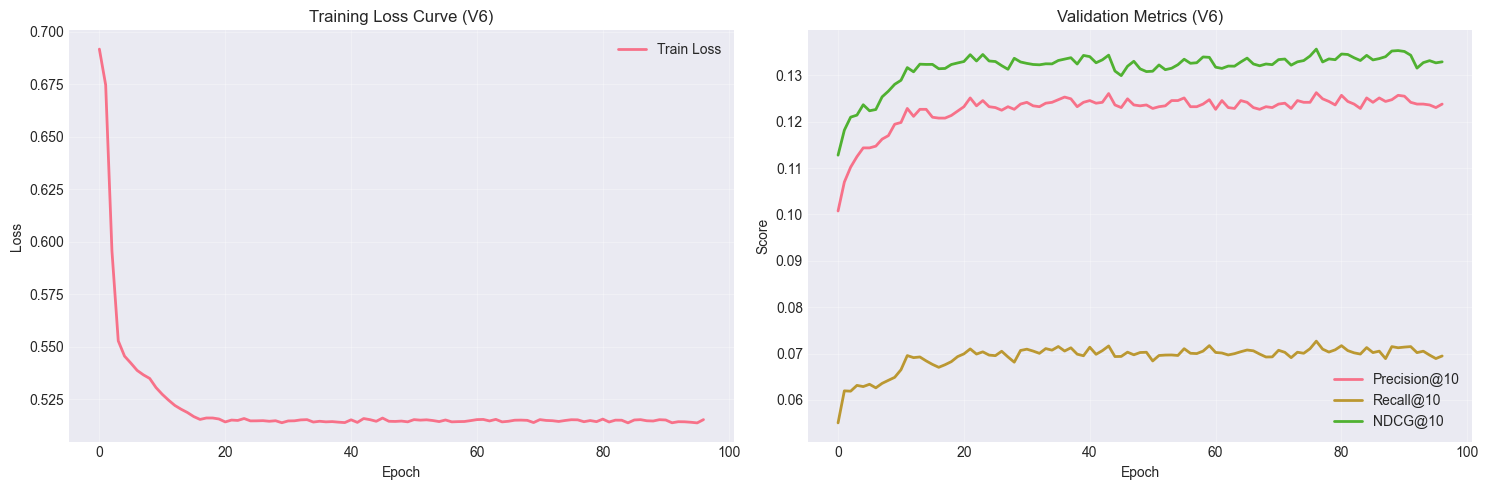

In [17]:
# Training 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve (V6)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['valid_precision'], label=f'Precision@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_recall'], label=f'Recall@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_ndcg'], label=f'NDCG@{CONFIG["top_k"]}', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics (V6)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'training_curves_v6.png'), dpi=300, bbox_inches='tight')
plt.show()

## Test Set 평가

In [18]:
# Test Set 평가
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_v6_best.pth')))

print("=" * 60)
print("Test Set 평가 (V6)")
print("=" * 60)

for k in [5, 10, 20]:
    test_metrics = evaluate_model(
        model, 
        train_valid_edge_index,
        test_df, 
        train_valid_user_items,
        n_items, 
        k=k, 
        device=CONFIG['device']
    )
    
    print(f"\nTop-{k} 추천:")
    print(f"  Precision@{k}: {test_metrics[f'precision@{k}']:.4f}")
    print(f"  Recall@{k}:    {test_metrics[f'recall@{k}']:.4f}")
    print(f"  NDCG@{k}:      {test_metrics[f'ndcg@{k}']:.4f}")

print("=" * 60)

Test Set 평가 (V6)

Top-5 추천:
  Precision@5: 0.1924
  Recall@5:    0.0475
  NDCG@5:      0.1980

Top-10 추천:
  Precision@10: 0.1633
  Recall@10:    0.0794
  NDCG@10:      0.1818

Top-20 추천:
  Precision@20: 0.1336
  Recall@20:    0.1256
  NDCG@20:      0.1768


## V6 vs V5 비교

In [19]:
print("=" * 60)
print("V6 vs V5 비교")
print("=" * 60)

print("\n데이터:")
print("  V5: Users=668, Items=10,321, Train=44,542")
print(f"  V6: Users={n_users}, Items={n_items}, Train={len(train_df):,}")

print("\nGraph 품질:")
print("  V5: Item degree mean=7.0, User-Item ratio=9.6x")
print(f"  V6: Item degree mean={item_degree.mean():.1f}, User-Item ratio={user_degree.mean()/item_degree.mean():.1f}x")

print("\n성능 (Test Recall@10):")
print("  V5: 7.84%")
print(f"  V6: [실행 후 기록]")
print(f"  목표: 15% 이상 (2배 향상)")

print("\n" + "=" * 60)

V6 vs V5 비교

데이터:
  V5: Users=668, Items=10,321, Train=44,542
  V6: Users=529, Items=2283, Train=56,072

Graph 품질:
  V5: Item degree mean=7.0, User-Item ratio=9.6x
  V6: Item degree mean=24.6, User-Item ratio=4.3x

성능 (Test Recall@10):
  V5: 7.84%
  V6: [실행 후 기록]
  목표: 15% 이상 (2배 향상)



## 다음 단계

### 성공 시 (Recall@10 > 15%)
- Graph 기반 방법론 유효 확인
- 추가 하이퍼파라미터 튜닝
- Loss function 개선 (InfoNCE 등)

### 부분 성공 (Recall@10: 10-15%)
- 일부 개선은 있지만 부족
- Filtering threshold 조정
- 다른 GNN 구조 시도 (GAT, SAGE)

### 실패 시 (Recall@10 < 10%)
- Graph 방법론이 여전히 부적합
- BPR-MF 기반으로 전환
- Neural CF 등 다른 접근 고려